In [1]:
from pathlib import Path
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from mne_connectivity import spectral_connectivity_epochs
from src.eeg_analysis.preprocessing.eeg_file import EEGFile
from src.eeg_analysis.preprocessing.eeg_preprocessor import EEGPreprocessor
from src.eeg_analysis.analysis.criticality import NeuronalAvalanche, PowerLawAnalyzer
from src.eeg_analysis.utils.helpers import calculate_z_score_eeg
from src.eeg_analysis.visualization.plots import plot_eeg
from src.eeg_analysis.visualization.my_custom_style import set_custom_style

In [2]:
participant_id = 1
base_dir = Path(r'D:\Anesthesia_Research_Fellow') / f'CA-{participant_id:02}'
base_path = base_dir / f'CA-{participant_id:02}'

vhdr_path = base_path.with_suffix('.vhdr')
vmrk_path = base_path.with_suffix('.vmrk')
eeg_path = base_path.with_suffix('.eeg')

eeg_file = EEGFile(participant_id, str(vhdr_path), str(vmrk_path), str(eeg_path))
eeg_file.load_data()

EEG Data Shape: (10477791, 21)


### Average phase lag index between channels during an example epoch

In [ ]:
preprocessor = EEGPreprocessor(eeg_file)

target_fs = 250
window_size = 10
step_size = 5
order = 5
low_cutoff = 0.5
high_cutoff = 55
epoch_length = 30

sequence_of_operations = [
    ('downsample', {'target_fs': target_fs}),
    ('create_epochs', {'events_df': eeg_file.events_df}),
    # ('detrend', {'window_size': window_size, 'step_size': step_size}),
    # ('re_reference', {'reference_type': 'average'}),
    ('bandpass_filter', {'order': order,'low_cutoff': low_cutoff, 'high_cutoff': high_cutoff}),
    ('exclude_noisy_periods', {'window_size':2, 'threshold':2, 'min_num_channels':4, 'padding':'zeros'})
]
preprocessor.process(sequence_of_operations)

In [4]:
sf = preprocessor.sampling_frequency
ch_names = preprocessor.channel_names[:16]
eeg = preprocessor.eeg_data['emergence'][:, :16] # , 600*sf

##### Divide the EEG signal into shorter segments for averaging 

In [ ]:
from src.eeg_analysis.preprocessing.eeg_preprocessor import EEGPreprocessor
eeg_segments, _ = EEGPreprocessor.get_segments(eeg, sf, 2)
eeg_segments = np.transpose(eeg_segments, (2, 1, 0)) # to make the arry compatible with mne_connectivity

In [22]:
eeg_segments.shape

(787, 16, 1250)

##### Calculate and compare various measures of phase lag index between example channels

In [ ]:
fmin = 1
fmax = 20

conn = []
indices = ([1, 1, 1, 1, 1], [2, 3, 4, 5, 6]) # between channel 1 and channels 1 to 5
for method in ["pli", "wpli", "dpli", "wpli2_debiased"]:
    conn.append(
        spectral_connectivity_epochs(
            eeg_segments,
            method=method,
            mode = 'multitaper',
            mt_bandwidth=2,
            # cwt_freqs= np.arange(9, 11, 20),
            sfreq=sf,
            indices=indices,
            fmin=fmin,
            fmax=fmax,
            faverage=True,
            verbose=False,
        ).get_data()[:, 0]
    )
conn = np.array(conn)

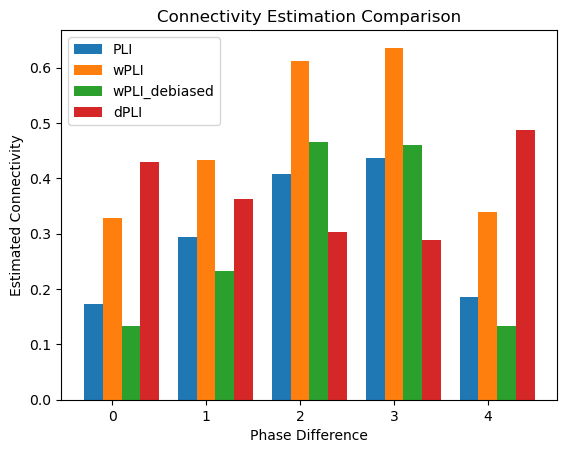

In [15]:
x = np.arange(5)

plt.figure()
plt.bar(x - 0.2, conn[0], 0.2, align="center", label="PLI")
plt.bar(x, conn[1], 0.2, align="center", label="wPLI")
plt.bar(x + 0.2, conn[3], 0.2, align="center", label="wPLI_debiased")
plt.bar(x + 0.4, conn[2], 0.2, align="center", label="dPLI")

plt.title("Connectivity Estimation Comparison")
# plt.xticks(x, (r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"))
plt.legend()
plt.xlabel("Phase Difference")
plt.ylabel("Estimated Connectivity")

plt.show()

##### Calculate various measure of phase lag index between all channels 

In [16]:
fmin = 1
fmax = 20

conn_wpli = spectral_connectivity_epochs(
    eeg_segments,
    method= 'wpli',
    mode = 'multitaper',
    # cwt_freqs= np.arange(9, 11, 20),
    sfreq=sf,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    verbose=False,
).get_data('dense')

conn_wpli_debiased = spectral_connectivity_epochs(
    eeg_segments,
    method= 'wpli2_debiased',
    mode = 'multitaper',
    # cwt_freqs= np.arange(9, 11, 20),
    sfreq=sf,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    verbose=False,
).get_data('dense')

conn_dpli = spectral_connectivity_epochs(
    eeg_segments,
    method= 'dpli',
    mode = 'multitaper',
    # cwt_freqs= np.arange(9, 11, 20),
    sfreq=sf,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    verbose=False,
).get_data('dense')

conn_pli = spectral_connectivity_epochs(
    eeg_segments,
    method= 'pli',
    mode = 'multitaper',
    # cwt_freqs= np.arange(9, 11, 20),
    sfreq=sf,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    verbose=False,
).get_data('dense')

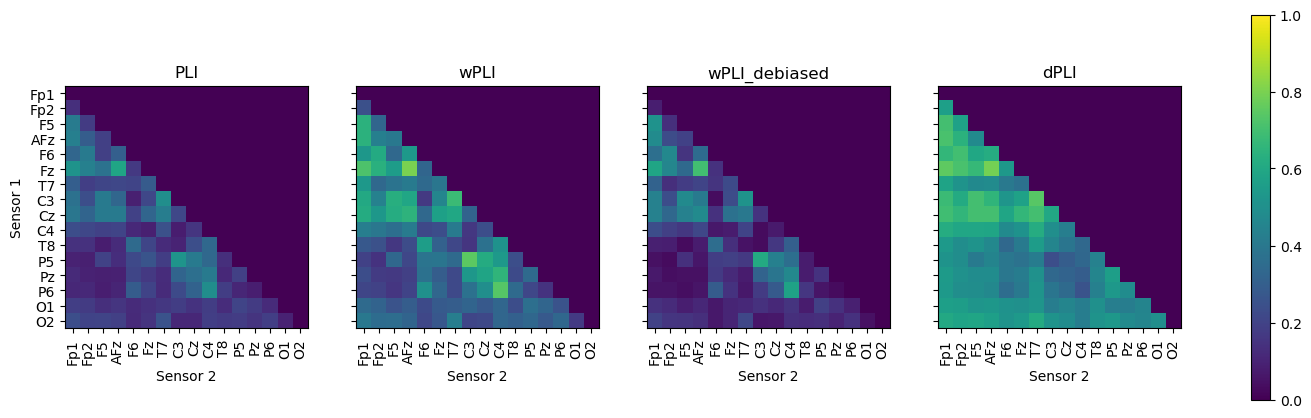

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharey=True)
axs[0].imshow(conn_pli, vmin=0, vmax=1)
axs[0].set_title("PLI")
axs[0].set_ylabel("Sensor 1")
axs[0].set_xlabel("Sensor 2")
axs[0].set_xticks(range(16))
axs[0].set_yticks(range(16))
axs[0].set_xticklabels(ch_names, rotation=90)
axs[0].set_yticklabels(ch_names)

axs[1].imshow(conn_wpli, vmin=0, vmax=1)
axs[1].set_title("wPLI")
axs[1].set_xlabel("Sensor 2")
axs[1].set_xticks(range(16))
axs[1].set_yticks(range(16))
axs[1].set_xticklabels(ch_names, rotation=90)
axs[1].set_yticklabels(ch_names)

axs[2].imshow(conn_wpli_debiased, vmin=0, vmax=1)
axs[2].set_title("wPLI_debiased")
axs[2].set_xlabel("Sensor 2")
axs[2].set_xticks(range(16))
axs[2].set_yticks(range(16))
axs[2].set_xticklabels(ch_names, rotation=90)
axs[2].set_yticklabels(ch_names)

im = axs[3].imshow(conn_dpli, vmin=0, vmax=1)
axs[3].set_title("dPLI")
axs[3].set_xlabel("Sensor 2")
axs[3].set_xticks(range(16))
axs[3].set_yticks(range(16))
axs[3].set_xticklabels(ch_names, rotation=90)
axs[3].set_yticklabels(ch_names)

fig.colorbar(im, ax=axs.ravel())
plt.show()

##### Clustering the channels based on the connectivity matrix (not functional)

In [24]:
# import scipy.cluster.hierarchy as spc
# pdist = spc.distance.pdist(conn_wpli_debiased[:, :, 0])
# linkage = spc.linkage(pdist, method='complete')
# idx = spc.fcluster(linkage, 0.6*pdist.max(), 'distance')
# print(idx)
# print(eeg_file.channel_names)

[2 2 2 2 1 1 2 1 1 2 3 3 3 3 2 2]
['Fp1', 'Fp2', 'F5', 'AFz', 'F6', 'Fz', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P5', 'Pz', 'P6', 'O1', 'O2', 'ACC16', 'ACC17', 'ACC18', 'Packet Counter', 'TRIGGER']


##### The histogram of connectivity values 
To check if the distribution of connectivity values is biploar

In [ ]:
plt.figure()
aa = conn_wpli_debiased.reshape(-1,1)
aa = aa[aa > 0]
plt.hist(aa)

### Time-resolved phase lag index between any two channels 

In [3]:
preprocessor = EEGPreprocessor(eeg_file)

target_fs = 250
window_size = 10
step_size = 5
order = 5
low_cutoff = 0.5
high_cutoff = 55
epoch_length = 30

sequence_of_operations = [
    ('downsample', {'target_fs': target_fs}),
    ('create_epochs', {'events_df': eeg_file.events_df}),
    # ('detrend', {'window_size': window_size, 'step_size': step_size}),
    # ('re_reference', {'reference_type': 'average'}),
    ('bandpass_filter', {'order': order,'low_cutoff': low_cutoff, 'high_cutoff': high_cutoff}),
    ('exclude_noisy_periods', {'window_size':2, 'threshold':2, 'min_num_channels':4, 'padding':'zeros'})
]
preprocessor.process(sequence_of_operations)

In [5]:
sf = preprocessor.sampling_frequency
ch_names = preprocessor.channel_names[:16]

eeg = preprocessor.eeg_data['emergence'][:, :16] # ['emergence']

# Divide the EEG data into smaller windows, with an example length of 5 minutes / 300 seconds with a defined overlap
# Later, we calculate the phase lag index for each window by averaging the values over smaller segments (with an example length of 10 ms) within that window.

eeg_windows, window_centers = EEGPreprocessor.get_segments(eeg, sf, 300, 0.5)
num_windows = eeg_windows.shape[2]
print(f'number of windows = {num_windows}')

number of windows = 25


In [ ]:
import warnings

# Global variable to store the problematic data
problematic_epoch = None

def custom_warning_handler(message, category, filename, lineno, file=None, line=None):
    global problematic_epoch
    print(f"Warning caught: {message}")
    print(f"Associated segment data:\n {problematic_epoch}")

def is_outlier(channel_data, threshold=3):
    """
    Determine whether a given channel data in an segment is an outlier based on a given threshold.
    
    Parameters:
    channel_data (ndarray): The channel data with shape (n_times,).
    threshold (float): The z-score threshold to determine outliers. Default is 3.
    
    Returns:
    bool: True if the channel data is an outlier, False otherwise.
    """
    global problematic_epoch
    problematic_epoch = channel_data  # Store the current channel data for debugging

    if np.all(channel_data == 0):
        return False  # If the channel data is all zeros, it's not an outlier

    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", RuntimeWarning)  # Catch all runtime warnings
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        if std == 0:
            return True  # Treat this as an outlier since std-dev is zero (constant signal)
        z_scores = np.abs((channel_data - mean) / std)
        
        if len(w) > 0:
            # Print the warning
            for warning in w:
                print(warning.message)
                print(f'Std deviation of channel data: {std}')

    return np.any(z_scores > threshold)

warnings.showwarning = custom_warning_handler  # Set the custom warning handler

# Frequency range for the connectivity analysis
fmin = 0.5
fmax = 55

# Calculate the shape of one connectivity matrix to know dimensions for zero-padding
sample_window, _ = EEGPreprocessor.get_segments(eeg_windows[:, :, 0], sf, 10)
sample_window = np.transpose(sample_window, (2, 1, 0))
sample_conn = spectral_connectivity_epochs(
    sample_window,
    method='wpli2_debiased',
    mode='multitaper',
    sfreq=sf,
    fmin=fmin,
    fmax=fmax,
    faverage=False,
    mt_adaptive=False,
    verbose=False
)
conn_shape = sample_conn.get_data(output='dense').shape

threshold = 6
conn_wpli = []
outlier_counts = []

for win_idx in range(num_windows): # [12]:
    print(f'window {win_idx + 1}', end='\r')
    window = eeg_windows[:, :, win_idx]

    # Dividing into smaller segments within each window for averaging 
    segments, _ = EEGPreprocessor.get_segments(window, sf, 10)
    segments = np.transpose(segments, (2, 1, 0))  # Transpose to match shape (n_epochs, n_channels, n_times)
    
    valid_segments = []
    outlier_count = 0
    for segment in segments:
        valid_epoch = np.copy(segment)
        for ch_idx in range(segment.shape[0]):  # Check each channel separately
            if is_outlier(segment[ch_idx, :], threshold):
                valid_epoch[ch_idx, :] = 0  # Zero-pad the noisy intervals
                outlier_count += 1
        valid_segments.append(valid_epoch)
    
    # Convert the list of valid segments back to ndarray
    valid_segments = np.array(valid_segments)
    outlier_counts.append(outlier_count)

    if not np.any(valid_segments):  # Check if all channels are zero-padded
        print(f"All channels in window {win_idx} are zero-padded. Adding zero-padded matrix.")
        zero_padded_conn = np.zeros(conn_shape)
        conn_wpli.append(zero_padded_conn)
        continue

    # Calculate spectral connectivity for each winment
    conn = spectral_connectivity_epochs(
        valid_segments,
        method='wpli2_debiased',
        mode='multitaper',
        sfreq=sf,
        fmin=fmin,
        fmax=fmax,
        faverage=False,
        mt_adaptive=False,
        verbose=False
    )

    # Retrieve connectivity data and append to the list
    wpli_data = conn.get_data(output='dense')
    conn_wpli.append(wpli_data)

# Convert list of arrays to a single ndarray with an additional dimension for time bins
conn_wpli = np.stack(conn_wpli, axis=-1) if conn_wpli else np.array([])


# Optionally, print the counts of outlier segments for each window
for idx, count in enumerate(outlier_counts):
    print(f"window {idx + 1} had {count} outlier segments.") 

In [ ]:
# plot the concatenated eeg after removing the segments with amplitude above a threshold and excluding them from 
# the calculation of phase lag index. Limit the above calculations to only one window with a decent number of outlier segments

concat_segments = np.concatenate(np.transpose(valid_segments, (0, 2, 1)), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

from src.eeg_analysis.utils.helpers import calculate_z_score_eeg
z_concat_segments = calculate_z_score_eeg(concat_segments, duration=300, sampling_rate=sf, peak_threshold=8)

from src.eeg_analysis.visualization.plots import plot_eeg
plot_eeg(z_concat_segments, sf, 10, ax)
ax.set_xlim([0, 50])

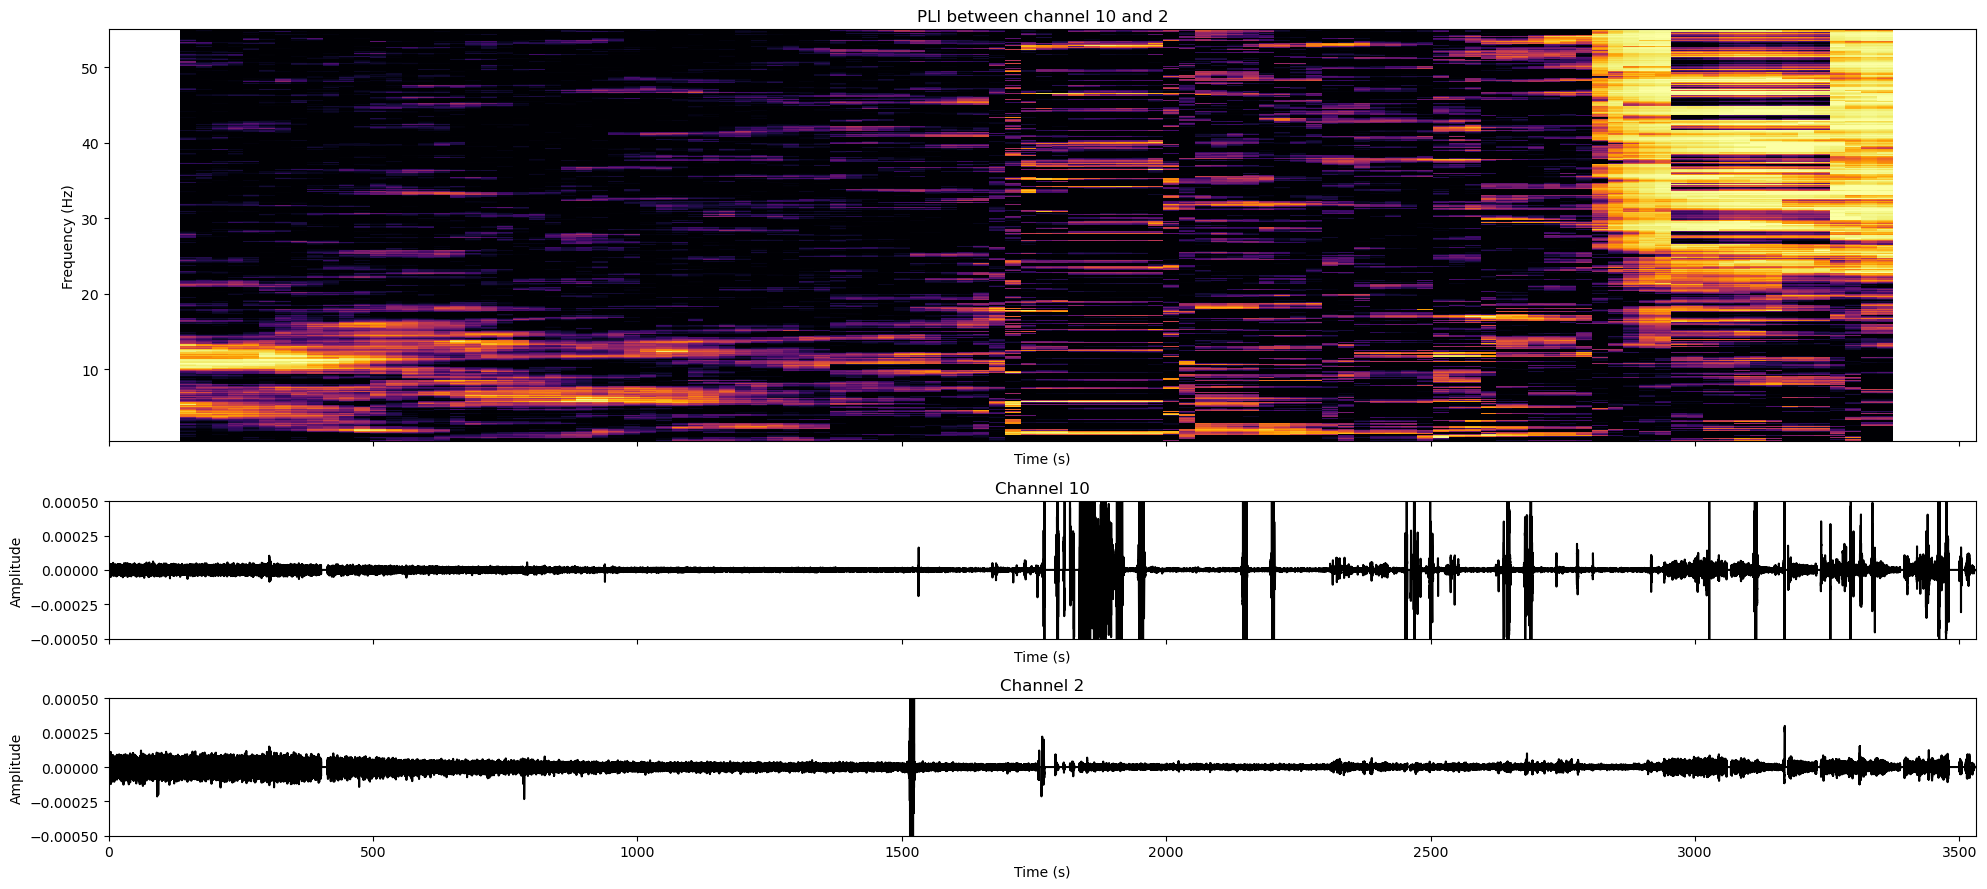

In [19]:
from scipy.ndimage import gaussian_filter


# Example: Plot PLI between two channels over time and frequency
ch1 = 10  # Channel 1 index
ch2 = 2 # Channel 2 index

time = np.arange(0, int(eeg.shape[0]/sf), 1/sf)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(20, 9), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True)

# Heatmap
pcm = axs[0].pcolormesh(
    np.array(window_centers), 
    np.arange(fmin, fmax+0.01, 0.1),
    gaussian_filter(conn_wpli[ch1, ch2, :, :], sigma=0), vmin = 0, vmax = 1, cmap='inferno'
)
axs[0].set_title(f'PLI between channel {ch1} and {ch2}')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Frequency (Hz)')
# fig.colorbar(pcm, ax=axs[0], label='PLI')

# Time-domain signal for Channel 1
axs[1].plot(time, eeg[:, ch1], color='k')
axs[1].set_title(f'Channel {ch1}')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].set_ylim([-0.0005, 0.0005])

# Time-domain signal for Channel 2
axs[2].plot(time, eeg[:, ch2], color='k')
axs[2].set_title(f'Channel {ch2}')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude')
axs[2].set_ylim([-0.0005, 0.0005])


axs[2].set_xlim([0, eeg.shape[0]/sf])
# axs[2].set_xlim([1500, 2000])

plt.tight_layout()
plt.show()

In [15]:
window_centers

[150.0,
 179.996,
 209.992,
 239.988,
 269.984,
 299.98,
 329.976,
 359.972,
 389.968,
 419.964,
 449.96,
 479.956,
 509.952,
 539.948,
 569.944,
 599.94,
 629.936,
 659.932,
 689.928,
 719.924,
 749.92,
 779.916,
 809.912,
 839.908,
 869.904,
 899.9,
 929.896,
 959.892,
 989.888,
 1019.884,
 1049.88,
 1079.876,
 1109.872,
 1139.868,
 1169.864,
 1199.86,
 1229.856,
 1259.852,
 1289.848,
 1319.844,
 1349.84,
 1379.836,
 1409.832,
 1439.828,
 1469.824,
 1499.82,
 1529.816,
 1559.812,
 1589.808,
 1619.804,
 1649.8,
 1679.796,
 1709.792,
 1739.788,
 1769.784,
 1799.78,
 1829.776,
 1859.772,
 1889.768,
 1919.764,
 1949.76,
 1979.756,
 2009.752,
 2039.748,
 2069.744,
 2099.74,
 2129.736,
 2159.732,
 2189.728,
 2219.724,
 2249.72,
 2279.716,
 2309.712,
 2339.708,
 2369.704,
 2399.7,
 2429.696,
 2459.692,
 2489.688,
 2519.684,
 2549.68,
 2579.676,
 2609.672,
 2639.668,
 2669.664,
 2699.66,
 2729.656,
 2759.652,
 2789.648,
 2819.644,
 2849.64,
 2879.636,
 2909.632,
 2939.628,
 2969.624,
 2999.6